In [4]:
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from math import factorial
from deap.benchmarks.tools import igd
from math import factorial
import warnings
from collections import defaultdict
import random
import tqdm
import geopandas as gpd
import folium

warnings.filterwarnings('ignore')

In [5]:
# Read in the travel times data
travel_times = pd.read_csv('./Travel_Times.csv')

travel_times = travel_times.dropna()


In [6]:
# Create a dictionary to store travel times
travel_times_dict = {(row["Home_LSOA"], row["Site_LSOA"]): row["TT"] for _, row in travel_times.iterrows()}

In [7]:
travel_times[travel_times['Home_LSOA'] == 'E01004801']
travel_times[travel_times['Home_LSOA'] == 'E01025104']


,Home_LSOA,Site_LSOA,TT


In [8]:

#Lets load the other data
sites = pd.read_csv('./Sites.csv', encoding='ISO-8859-1')
activities = pd.read_csv('./CC_Data.csv', encoding='ISO-8859-1')

sites = sites.loc[:, ['UnitCode', 'LSOA','NICU','LCU','SCBU']]
activities_orig = activities.loc[:, ['Der_Postcode_LSOA_Code','CC_Activity_Date','SiteLSOA', 'CC_Level']]
activities = activities.loc[:, ['Der_Postcode_LSOA_Code','CC_Activity_Date','SiteLSOA', 'CC_Level']]

#lets be brutal about this for now.. but we will need to clean our data properly at some point
sites = sites.replace('', np.nan)
sites = sites.dropna()
activities = activities.replace('', np.nan)
activities = activities.dropna()

site_lookup =  sites.loc[:, ['UnitCode', 'LSOA']]

# Ensure the date is a date
activities['CC_Activity_Date'] = pd.to_datetime(activities['CC_Activity_Date'], format='%d/%m/%Y')
activities = activities.set_index('Der_Postcode_LSOA_Code')


#Lets define some useful lists about our data
site_codes = sites['LSOA'].unique().tolist()
site_codes.remove("E01025104")
activity_types = activities['CC_Level'].unique().tolist()

#Lets define the time periods for the analysis
start_date = pd.Timestamp('2021-04-01')
end_date = pd.Timestamp('2022-03-31')
time_periods = pd.date_range(start_date, end_date, freq='D')

filtered_activities = activities.loc[(activities['CC_Activity_Date'] >= start_date) & (activities['CC_Activity_Date'] <= end_date)]

home_lsoas = filtered_activities.index.unique().tolist()
home_level_activities_count = filtered_activities.groupby(["Der_Postcode_LSOA_Code", "CC_Level"]).size().to_dict()
home_activities_count = filtered_activities.groupby(["CC_Activity_Date","Der_Postcode_LSOA_Code"]).size().to_dict()
home_activities_count

activities.head()

,CC_Activity_Date,SiteLSOA,CC_Level
Der_Postcode_LSOA_Code,,,
E01025106,2021-06-13,E01025104,SCBU
E01025106,2021-06-15,E01025104,SCBU
E01025113,2021-05-23,E01025104,SCBU
E01025113,2021-05-25,E01025104,SCBU
E01025113,2021-05-27,E01025104,SCBU


In [9]:
home_activities_dict = activities.groupby('Der_Postcode_LSOA_Code')['CC_Level'].value_counts().unstack(fill_value=0).to_dict(orient='index')
home_activities_dict

{'E01000065': {'LCU': 0, 'NICU': 0, 'SCBU': 16},
 'E01003610': {'LCU': 0, 'NICU': 0, 'SCBU': 22},
 'E01003613': {'LCU': 0, 'NICU': 0, 'SCBU': 1},
 'E01003952': {'LCU': 0, 'NICU': 0, 'SCBU': 2},
 'E01004770': {'LCU': 0, 'NICU': 0, 'SCBU': 8},
 'E01004775': {'LCU': 0, 'NICU': 3, 'SCBU': 18},
 'E01004779': {'LCU': 1, 'NICU': 0, 'SCBU': 4},
 'E01004780': {'LCU': 3, 'NICU': 2, 'SCBU': 10},
 'E01004781': {'LCU': 1, 'NICU': 0, 'SCBU': 18},
 'E01004787': {'LCU': 0, 'NICU': 0, 'SCBU': 3},
 'E01004794': {'LCU': 1, 'NICU': 1, 'SCBU': 1},
 'E01004795': {'LCU': 1, 'NICU': 0, 'SCBU': 7},
 'E01004797': {'LCU': 0, 'NICU': 0, 'SCBU': 7},
 'E01004801': {'LCU': 0, 'NICU': 0, 'SCBU': 5},
 'E01004802': {'LCU': 0, 'NICU': 0, 'SCBU': 3},
 'E01004804': {'LCU': 0, 'NICU': 0, 'SCBU': 6},
 'E01004806': {'LCU': 0, 'NICU': 2, 'SCBU': 4},
 'E01004809': {'LCU': 0, 'NICU': 0, 'SCBU': 1},
 'E01004810': {'LCU': 0, 'NICU': 0, 'SCBU': 3},
 'E01004811': {'LCU': 0, 'NICU': 0, 'SCBU': 6},
 'E01004812': {'LCU': 0, 'NICU': 0,

   	      	          big_sites           	                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   population                                                                                                                                                 

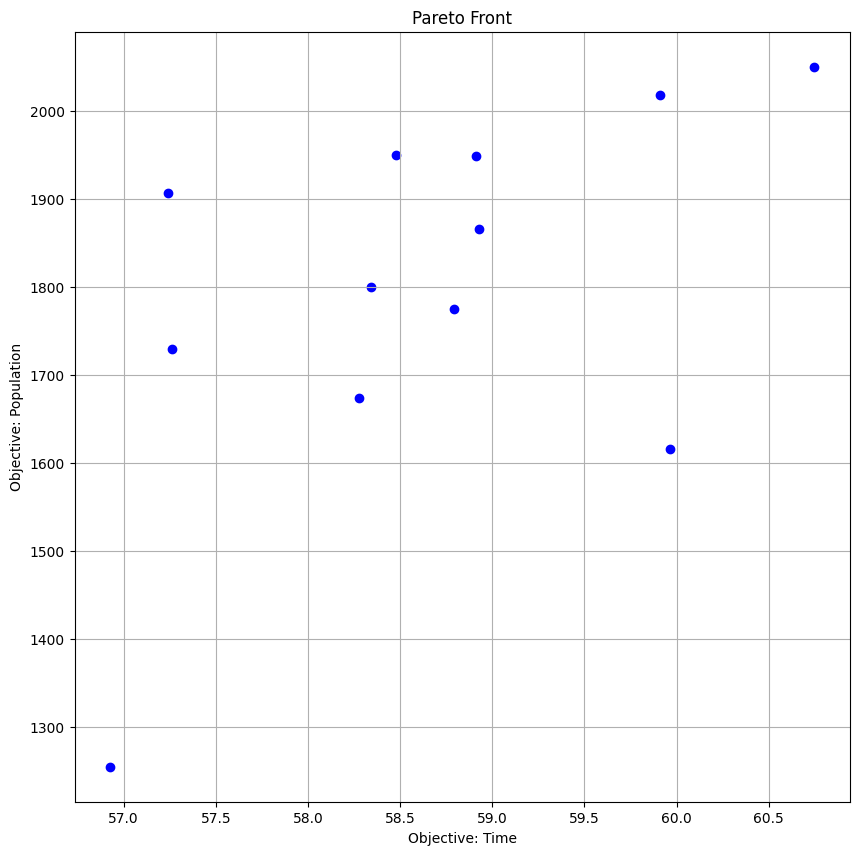

In [12]:
# # create a dictionary to map each site to a unique integer
# site_to_int = {site: i for i, site in enumerate(site_codes)}
# int_to_site = {i: site for i, site in enumerate(site_codes)}

# # create a dictionary to map each home to a unique integer
# home_to_int = {home: i for i, home in enumerate(home_lsoas)}
# int_to_home = {i: home for i, home in enumerate(home_lsoas)}

pop_num = 200
cross_chance = 0.4
mutation_prob = 0.2
number_generations = 100


logs_df = pd.DataFrame(columns=['individual', 'avg_time', 'small_site_population', 'prop_within_30_mins', 'sites_over_2000_admissions'])

# Number of homes and sites
num_homes = len(home_lsoas)
num_sites = len(site_codes)

activity_to_int = {activity: i for i, activity in enumerate(activities['CC_Level'].unique())}
int_to_activity = {i: activity for i, activity in enumerate(activities['CC_Level'].unique())}


# Group by DER_Postcode_LSOA_Code and count the occurrences
home_populations_dict = activities.groupby('Der_Postcode_LSOA_Code').size().to_dict()
home_activities_dict = activities.groupby('Der_Postcode_LSOA_Code')['CC_Level'].value_counts().unstack(fill_value=0).to_dict(orient='index')
home_activities = [[home_activities_dict[home][int_to_activity[i]] for i in range(3)] for home in home_lsoas]


# Convert it to list matching the order of home_lsoas
home_populations = [home_populations_dict[home] for home in home_lsoas]

# For multi-objective: minimize time, maximize assignment to smallest site
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0, 1.0, 1.0)) 
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

toolbox.register("random_site", random.randint, 0, num_sites-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.random_site, num_homes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def eval_func(individual):
    total_time = 0
    activity_counts = defaultdict(lambda: [0, 0, 0])
    within_30_mins = 0
    total_population = 0
    for home_idx, site_idx in enumerate(individual):
        home = home_lsoas[home_idx]
        site = site_codes[site_idx]
        if (home, site) in travel_times_dict:
            travel_time = travel_times_dict[(home, site)]
            total_time += travel_time
            total_population += home_populations[home_idx]
            if travel_time <= 30:
                within_30_mins += home_populations[home_idx]
            # Get this home's activity counts
            activity_counts_per_home = home_activities[home_idx]  
            for i in range(3):
                activity_counts[site][i] += activity_counts_per_home[i]
    
    avg_time = total_time / len(individual) if len(individual) != 0 else 0
    # Use activity_counts to find the minimum total activities at any site
    small_site_population = min(sum(ac) for ac in activity_counts.values())
    prop_within_30_mins = within_30_mins / total_population if total_population != 0 else 0
    sites_over_2000_admissions = sum(1 for activity_count in activity_counts.values() if sum(activity_count) > 2000)
    
    global logs_df  # Make sure to use the global variable
    
    # Add a new row to the DataFrame
    logs_df = logs_df.append({
        'individual': individual,  # This might be quite large, consider hashing or summarizing instead
        'avg_time': avg_time,
        'small_site_population': small_site_population,
        'prop_within_30_mins': prop_within_30_mins,
        'sites_over_2000_admissions': sites_over_2000_admissions
    }, ignore_index=True)
    
    
    return avg_time, small_site_population, prop_within_30_mins, sites_over_2000_admissions


toolbox.register("evaluate", eval_func)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=num_sites-1, indpb=0.05)
toolbox.register("select", tools.selNSGA2)


def main():
    random.seed(0)
    pop = toolbox.population(n=pop_num)
    hof = tools.HallOfFame(1)

    # Define statistics for each objective
    stats_time = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    stats_time.register("avg_time", np.mean)

    stats_population = tools.Statistics(key=lambda ind: ind.fitness.values[1])
    stats_population.register("populations", lambda values: values)


    stats_prop = tools.Statistics(key=lambda ind: ind.fitness.values[2])
    stats_prop.register("avg_prop", np.mean)

    # Define a custom function to count the number of individuals with more than 2000 activities
    def count_large_sites(values):
        return sum(1 for val in values if val > 0)
    
    stats_large_sites = tools.Statistics(key=lambda ind: ind.fitness.values[3])
    stats_large_sites.register("2000_activities", count_large_sites)
    
    # Combine statistics into MultiStatistics
    mstats = tools.MultiStatistics(time=stats_time, population=stats_population, prop=stats_prop, big_sites = stats_large_sites)
    
    # Use mstats instead of the previous stats object
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cross_chance, mutpb=mutation_prob, ngen=number_generations, 
                                   stats=mstats, halloffame=hof, verbose=True)
    
    pareto_front = tools.sortNondominated(pop, len(pop), first_front_only=True)[0]
    
    return pop, log, hof, pareto_front


def plot_pareto_front(pareto_front):
    objectives_time = [ind.fitness.values[0] for ind in pareto_front]
    objectives_population = [ind.fitness.values[1] for ind in pareto_front]

    plt.figure(figsize=(10, 10))
    plt.scatter(objectives_time, objectives_population, c="blue")
    plt.title("Pareto Front")
    plt.xlabel("Objective: Time")
    plt.ylabel("Objective: Population")
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    pop, log, hof, pareto_front = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

    # Here we translate the best individual (which is a list of site indices) into a list of (home_code, site_code) pairs
    solution = []
    for i, site_index in enumerate(hof[0]):
        home_code = home_lsoas[i]
        site_code = site_codes[site_index]
        solution.append((home_code, site_code))

    # Now we can create a dictionary that maps each home to a site
    home_to_site_mapping = dict(solution)

    # Now you can print this mapping or use it in further processing
    print("Home to site mapping:")
    print(home_to_site_mapping)

    # Next, let's count the number of activities at each site
    activity_counts = defaultdict(lambda: [0, 0, 0])
    for home_code, site_code in solution:
        activity_counts_per_home = home_activities_dict[home_code]  # get this home's activity counts
        for i in range(3):  # for each type of activity
            activity_counts[site_code][i] += activity_counts_per_home[int_to_activity[i]]


    print("Activity counts per site:")
    print(activity_counts)

    # Initialize the dictionary
    home_to_site_mapping = defaultdict(list)

    # Go through each (home_code, site_code) pair in the solution list
    for home_code, site_code in solution:
        # Add the home code to the list of homes assigned to this site
        home_to_site_mapping[site_code].append(home_code)

    print("Home to site mapping:")
    print(home_to_site_mapping)
    
    plot_pareto_front(pareto_front)
    
    
    



In [ ]:
logs_df

,individual,avg_time,small_site_population,prop_within_30_mins,sites_over_2000_admissions
0,"[12, 13, 1, 8, 16, 15, 12, 9, 15, 11, 18, 6, 1...",59.034189,1796,0.154401,18
1,"[16, 20, 9, 1, 0, 12, 10, 5, 17, 4, 5, 5, 5, 2...",59.233920,1636,0.136774,15
2,"[12, 12, 1, 4, 14, 2, 9, 20, 4, 16, 6, 19, 15,...",58.464647,1860,0.143699,18
3,"[12, 6, 0, 12, 20, 18, 17, 9, 12, 19, 0, 17, 3...",58.014263,1582,0.162578,17
4,"[20, 13, 10, 3, 0, 6, 20, 9, 2, 6, 9, 2, 6, 5,...",58.520643,1468,0.146910,15
...,...,...,...,...,...
671,"[20, 16, 10, 4, 9, 6, 8, 5, 3, 18, 15, 1, 0, 2...",58.926806,1653,0.124114,18
672,"[14, 7, 8, 11, 15, 8, 16, 11, 3, 0, 10, 3, 13,...",60.361420,1454,0.124861,15
673,"[6, 0, 2, 14, 11, 6, 12, 13, 1, 2, 11, 17, 6, ...",60.542465,1612,0.101460,17
674,"[19, 5, 13, 11, 6, 20, 20, 19, 9, 2, 4, 20, 5,...",60.531736,1714,0.120884,17


: 

In [ ]:
site_populations

NameError: name 'site_populations' is not defined

In [ ]:
home_activities_dict
home_activities_with_code = home_activities_dict.copy()

# Convert it to a list of tuples
home_activities_list = [(home_code, activities) for home_code, activities in home_activities_with_code.items()]
home_activities_list                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

[('E01000065', {'LCU': 0, 'NICU': 0, 'SCBU': 16}),
 ('E01003610', {'LCU': 0, 'NICU': 0, 'SCBU': 22}),
 ('E01003613', {'LCU': 0, 'NICU': 0, 'SCBU': 1}),
 ('E01003952', {'LCU': 0, 'NICU': 0, 'SCBU': 2}),
 ('E01004770', {'LCU': 0, 'NICU': 0, 'SCBU': 8}),
 ('E01004775', {'LCU': 0, 'NICU': 3, 'SCBU': 18}),
 ('E01004779', {'LCU': 1, 'NICU': 0, 'SCBU': 4}),
 ('E01004780', {'LCU': 3, 'NICU': 2, 'SCBU': 10}),
 ('E01004781', {'LCU': 1, 'NICU': 0, 'SCBU': 18}),
 ('E01004787', {'LCU': 0, 'NICU': 0, 'SCBU': 3}),
 ('E01004794', {'LCU': 1, 'NICU': 1, 'SCBU': 1}),
 ('E01004795', {'LCU': 1, 'NICU': 0, 'SCBU': 7}),
 ('E01004797', {'LCU': 0, 'NICU': 0, 'SCBU': 7}),
 ('E01004801', {'LCU': 0, 'NICU': 0, 'SCBU': 5}),
 ('E01004802', {'LCU': 0, 'NICU': 0, 'SCBU': 3}),
 ('E01004804', {'LCU': 0, 'NICU': 0, 'SCBU': 6}),
 ('E01004806', {'LCU': 0, 'NICU': 2, 'SCBU': 4}),
 ('E01004809', {'LCU': 0, 'NICU': 0, 'SCBU': 1}),
 ('E01004810', {'LCU': 0, 'NICU': 0, 'SCBU': 3}),
 ('E01004811', {'LCU': 0, 'NICU': 0, 'SCBU': 

In [ ]:
import geopandas as gpd
import folium

# Load the LSOA shapefile
lsoas = gpd.read_file('./LSOA_Dec_2011_PWC_in_England_and_Wales/LSOA_Dec_2011_PWC_in_England_and_Wales.shp')

# Convert your mapping to a DataFrame
home_to_site_df = pd.DataFrame.from_dict(home_to_site_mapping, orient='index', columns=['SiteCode'])
home_to_site_df.index.name = 'LSOA_Code'
home_to_site_df.reset_index(inplace=True)

# Merge the shapefile with the DataFrame
merged = lsoas.set_index('LSOA_Code').join(home_to_site_df.set_index('LSOA_Code'))

# Now you can plot the LSOA boundaries and color them by the site they are assigned to
map = folium.Map(location=[latitude, longitude], zoom_start=13)  # set the initial location and zoom level

# Plot each polygon on the map
for _, row in merged.iterrows():
    # Get the shape
    shape = row['geometry']
    # Get the site code
    site_code = row['SiteCode']
    # Create a folium Polygon
    polygon = folium.vector_layers.Polygon(locations=[list(x) for x in shape.exterior.coords],
                                           fill=True,
                                           color='blue' if site_code == 'some_site_code' else 'red')  # just an example
    # Add it to the map
    polygon.add_to(map)

# Display the map
map.save(outfile='map.html')


ValueError: 1 columns passed, passed data had 98 columns